Visualizing Missingness

Overall missingness in features: 99.05%
Number of features with any missingness: 9961 out of 9961


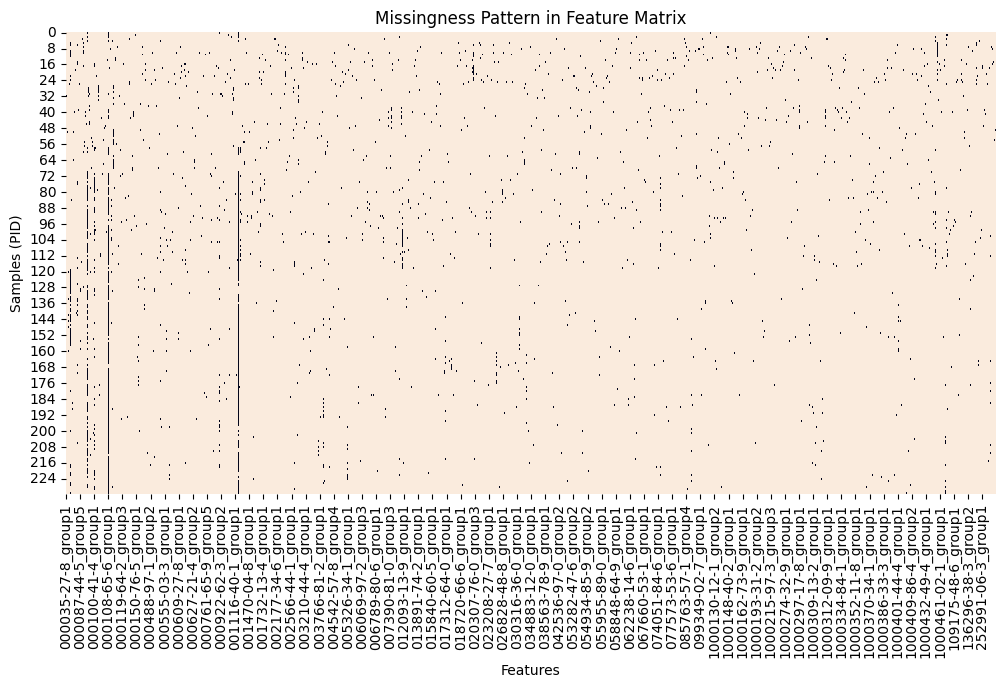

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loading data
df_main2_cleaned = pd.read_csv('df_main2_cleaned.csv')

# Excluding demos
feature_cols = [col for col in df_main2_cleaned.columns if col not in ['PID', 'TB Status', 'Age', 'BMI', 'HIV Status']]
# dtype issue correction. It will still throw a warning, but the line below resolves this
df_main2_cleaned[feature_cols] = df_main2_cleaned[feature_cols].apply(pd.to_numeric, errors='coerce')


# How much is missing
missing_perc = df_main2_cleaned[feature_cols].isnull().mean().mean() * 100
print(f"Overall missingness in features: {missing_perc:.2f}%")

# How many features are missing
features_with_missing = df_main2_cleaned[feature_cols].isnull().any().sum()
print(f"Number of features with any missingness: {features_with_missing} out of {len(feature_cols)}")

# Visualization
plt.figure(figsize=(12, 6))
sns.heatmap(df_main2_cleaned[feature_cols].isnull(), cbar=False)
plt.title('Missingness Pattern in Feature Matrix')
plt.xlabel('Features')
plt.ylabel('Samples (PID)')
plt.show()

In [2]:
# Filter to keep only features present >=10% of samples
min_present = len(df_main2_cleaned) * 0.10
filtered_features = [col for col in feature_cols if df_main2_cleaned[col].notnull().sum() >= min_present]
print(f"Features retained after filtering: {len(filtered_features)}")
df_main2_clean_filter = df_main2_cleaned[filtered_features]

Features retained after filtering: 79


This is a huge drop in features, but not suprising. Dropping from 10,400 to 79 seems reasonable as this is exhalled VOCs.

**NOTE:** Unable to use BaylorEdPsych package for Little's MCAR does not work with current versions of R and is a noted grevience in the community. The same goes for running QRILC with the imputeLCMD package. Packages for R 4.4 have not been udpated which is why they are not working. 

Using R 3.6.3 in a Docker to use imputeLCMD package. RF was attempted using the MissForest algorithm (Stekhoven & Bühlmann, 2012) implemented in R (v4.4.0) via the missForest package, but was decided inapropriate given the missingness nature of this GCMS data being NCAR.  **WRITE THIS UP NICER**

In [3]:
# Exporting df for use in Docker image
df_main2_clean_filter.to_csv("df_to_impute.csv", index=False)  # <- place this in same folder as the Docker

**NOTE** This is where the R Docker script should be run

* run 'make' in terminal after navigating to folder
* run 'docker run -it --rm -v "$(PWD)":/home/ruser/data impute_lcmd_r Rscript /home/ruser/data/imputation_script.R'' after container is built

In [4]:
# Importing df from R post imputation with imputeLCMD package
imputed = pd.read_csv("imputed_output.csv")  # <- will need to copy this from the Docker folder to the Jupyter Area

# R named the CAS-RT Groups differently. Replacing original style:
imputed.columns = df_main2_clean_filter.columns

# pulling PID and demographic columns back in from df_main2_cleaned
df_main3 = pd.concat([
    df_main2_cleaned[['PID', 'TB Status', 'Age', 'BMI', 'HIV Status']].reset_index(drop=True),
    imputed
], axis=1)

**NOTE TO SELF** we skipped TIC because they already should have been TIC'd before. 

Running df_main3.describe() confirms this

In [5]:
df_main3.describe()  # QC step to confirm TIC already occured

,Age,BMI,000067-64-1_group2,000067-68-5_group1,000074-95-3_group1,000074-97-5_group1,000077-68-9_group1,000078-79-5_group2,000078-93-3_group1,000091-20-3_group1,...,038165-93-4_group1,054446-78-5_group1,063521-76-6_group3,095798-15-5_group1,1000132-10-9_group2,1000308-17-8_group1,1000309-13-0_group1,1000386-40-2_group1,1000401-12-0_group1,1000417-00-6_group1
count,232.00000,230.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,...,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000
mean,36.25000,21.131345,0.238537,-0.120381,-0.026903,0.728999,0.075115,-0.178280,-0.080057,0.266420,...,0.061868,-0.162472,-0.148801,-0.398209,-0.011765,-0.123597,-0.279006,-0.345818,-0.080249,-0.106319
std,11.30902,4.394879,0.301522,0.153266,0.066485,1.053057,0.153851,0.425743,0.127875,0.175813,...,0.690869,0.231388,0.170788,0.739679,0.051162,0.120602,0.372235,0.303044,0.127549,0.123688
min,18.00000,13.714286,-0.388743,-0.467829,-0.204719,-0.752586,-0.226879,-0.824413,-0.350509,-0.186629,...,-0.810912,-0.637823,-0.576037,-0.977527,-0.141061,-0.456927,-0.852014,-0.852036,-0.388901,-0.398209
25%,27.00000,17.993080,0.038692,-0.230679,-0.070846,0.009829,-0.027740,-0.481336,-0.166850,0.144859,...,-0.426807,-0.330419,-0.264628,-0.826146,-0.043198,-0.206708,-0.558929,-0.538696,-0.170779,-0.205258
50%,35.00000,20.618645,0.191482,-0.131024,-0.029725,0.346074,0.053086,-0.298197,-0.093467,0.277350,...,-0.128135,-0.189082,-0.147789,-0.658965,-0.010847,-0.133530,-0.359555,-0.418224,-0.089365,-0.108646
75%,45.00000,23.363298,0.452700,-0.044154,0.012441,1.464500,0.157800,0.029331,-0.001089,0.380625,...,0.292231,-0.033199,-0.059399,-0.305779,0.018718,-0.048915,-0.093238,-0.199726,0.011421,-0.017081
max,72.00000,38.514057,1.049000,0.351500,0.154200,6.480900,0.792200,1.838300,0.637400,0.789400,...,2.821900,0.790700,0.355700,3.918500,0.123300,0.262400,1.393500,0.907900,0.267300,0.213800


**Z-Scoring data**

Z-scored feature means (should be ~0):000067-64-1_group2    -5.359697e-17
000067-68-5_group1     0.000000e+00
000074-95-3_group1     3.062684e-17
000074-97-5_group1    -1.225074e-16
000077-68-9_group1    -6.125368e-17
                           ...     
1000308-17-8_group1    3.062684e-17
1000309-13-0_group1   -1.531342e-17
1000386-40-2_group1    1.531342e-17
1000401-12-0_group1    6.125368e-17
1000417-00-6_group1    7.656711e-18
Length: 79, dtype: float64 

Z-scored feature std devs (should be ~1): 000067-64-1_group2     1.002162
000067-68-5_group1     1.002162
000074-95-3_group1     1.002162
000074-97-5_group1     1.002162
000077-68-9_group1     1.002162
                         ...   
1000308-17-8_group1    1.002162
1000309-13-0_group1    1.002162
1000386-40-2_group1    1.002162
1000401-12-0_group1    1.002162
1000417-00-6_group1    1.002162
Length: 79, dtype: float64 



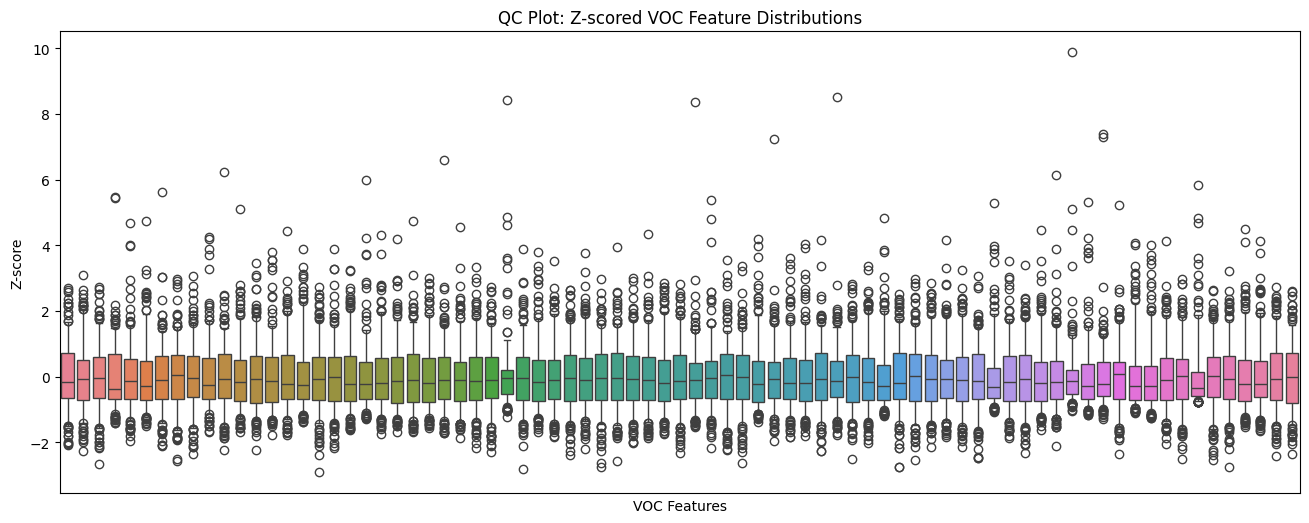

In [6]:
from sklearn.preprocessing import StandardScaler

# Extract VOC feature columns
feature_cols = df_main2_clean_filter.columns  # same 79 features

scaler = StandardScaler()
df_main3_z = df_main3.copy()
df_main3_z[feature_cols] = scaler.fit_transform(df_main3[feature_cols])

# QC
print(f"Z-scored feature means (should be ~0):{df_main3_z[feature_cols].mean()} \n")
print(f"Z-scored feature std devs (should be ~1): {df_main3_z[feature_cols].std()} \n")

# Boxplot
plt.figure(figsize=(16, 6))
sns.boxplot(data=df_main3_z[feature_cols], whis=[5, 95])
plt.title('QC Plot: Z-scored VOC Feature Distributions')
plt.xlabel('VOC Features')
plt.ylabel('Z-score')
plt.xticks([], [])  # x-axis labels hidden for clarity bc so many features
plt.show()

When looking at the above plot...
* no one feature stands out more than another
* Most are centered around 0
* IQR mostly between +/- 1
* Outliers are both above and below which seems to make sense given variability of breath based VOCs

**QC checks out, normalization worked**

In [7]:
# switching data into 0 and 1 format
df_main3_z['TB Status'] = df_main3_z['TB Status'].map({'Negative': 0, 'Positive': 1})
df_main3_z['HIV Status'] = df_main3_z['HIV Status'].map({'Negative': 0, 'Positive': 1})
df_main3_z['HIV Status'] = df_main3_z['HIV Status'].fillna(-1)
df_main3_z['Age'] = df_main3_z['Age'].fillna(-1)
df_main3_z['BMI'] = df_main3_z['BMI'].fillna(-1)
# saving
df_main3_z.to_csv('df_main_normalized.csv', index=False)